# Predicting Player's On-Base Percentage (OBP) for the 2021 MLB Season
### By: Gibson Hurst

## Introduction
This Bayesian analysis aims to predict each player's on-base percentage (OBP) for the 2021 MLB season, including players debuting in 2021, using plate appearances (PA), and on-base percentages (OBP) from previous seasons (2016-2020). The success of my model will be evaluated primarily through LOO Cross Validation and Mean Squared Error (MSE) in comparison to baseline methods.

## Credits
Inspiration for some of the code structure came from thes resources:
- *Bayesian Analysis with Python (Third Edition)* by Osvaldo Martin
  - Code for each chapter: https://github.com/aloctavodia/BAP3/tree/main/code
- ChatGPT

I also applied a few of my favorite best practices I learned from:
- *Designing Machine Learning Systems* by Chip Huyen
- *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron


## Import Data

In [819]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.random.seed(123)

In [820]:
data = pd.read_csv("https://raw.githubusercontent.com/GibsonHurst/OBP_Model_Phillies_QA_Job_Opp/main/obp.csv")

In [821]:
data['birth_date'] = pd.to_datetime(data['birth_date'], format='%m/%d/%y')

## Train Test Split

To simulate a real-world scenario in which I develop this model for the upcoming 2021 season, I excluded any 2021 data from the training dataset to prevent data leakage and ensure that my model remains uninfluenced by "future" data.

In [822]:
test = data.copy()
train = data.copy()
train = train.drop(['PA_21', 'OBP_21'], axis=1)

# Exploratory Data Analysis

I engineered additional features, identified missing values, and searched for any significant changes in league OBP or PA over time. My focus was on identifying features with the strongest correlation with `OBP_20` and reviewing scatterplots for non-linear relationships. These features should provide a balanced overview of recent and more long-term performance trends of each player.

The newly created features are:
- **OBP_Avg**: Each player's average on-base percentage over the 2016-2019 seasons. This feature captures a player's general ability to reach base over multiple seasons, which may be more predictive than performance in a single season.
- **PA_Avg**: Each player's average plate appearances over the 2016-2019 seasons. This feature accounts for the player's consistency over several years, which could predict their performance in the future.
- **Age**: Player's age as of 2020. Player performace tends to vary over the course of a career which will be captured by this feature.
- **Years_Exp**: Player's number of years of experience before the 2020 season. Experience could correlate with player ability. 
- **TOB_Avg**:  An approximation of Time on Base for each player over the 2016-2019 seasons, calculated as `OBP_Avg * PA_Avg`. This feature gives a decent overview of a player's offensive contribution, over many seasons, which could predict OBP performace. 
- **TOB_19**: An approximation of Time on Base for each player in 2019, calculated as `OBP_19 * PA_19`.

In [823]:
eda = train.copy()
eda['OBP_Avg'] = eda[['OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].mean(axis=1)
eda['PA_Avg'] = eda[['PA_19', 'PA_18', 'PA_17', 'PA_16']].mean(axis=1)
eda['Age'] = (pd.to_datetime('2020-01-01') - eda['birth_date']).dt.days / 365.25
eda['Years_Exp'] = eda[['OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].count(axis=1)
eda['TOB_Avg'] = eda['OBP_Avg'] * eda['PA_Avg']
eda['TOB_19'] = eda['OBP_19'] * eda['PA_19']

### Missing Value Check

Approximately 20% of players lack metrics from the 2016-2020 seasons, suggesting they are likely debuting in 2021. Thus, my feature selection and model needs to accommodate these new players when making inferences for the 2021 season.

In [824]:
eda.isnull().sum() / len(eda)

Name          0.000000
playerid      0.000000
birth_date    0.000000
PA_20         0.185315
OBP_20        0.185315
PA_19         0.236014
OBP_19        0.236014
PA_18         0.372378
OBP_18        0.372378
PA_17         0.479021
OBP_17        0.479021
PA_16         0.568182
OBP_16        0.568182
OBP_Avg       0.216783
PA_Avg        0.216783
Age           0.000000
Years_Exp     0.000000
TOB_Avg       0.216783
TOB_19        0.236014
dtype: float64

### Leauge OBP & PA Trends

The distribution of OBP remains centered around 0.32 each year and is normally distributed. OBP variation increased in 2020, likely due to smaller sample sizes (lower PA) because of Covid-19. The distribution of PA remains centered around 350 until Covid-19 impacted the 2020 season. Given the consistent OBP patterns observed across seasons, I can model OBP for 2020 `OBP_20` and reasonably assume that the coefficients derived will still be applicable for predicting `OBP_21`.

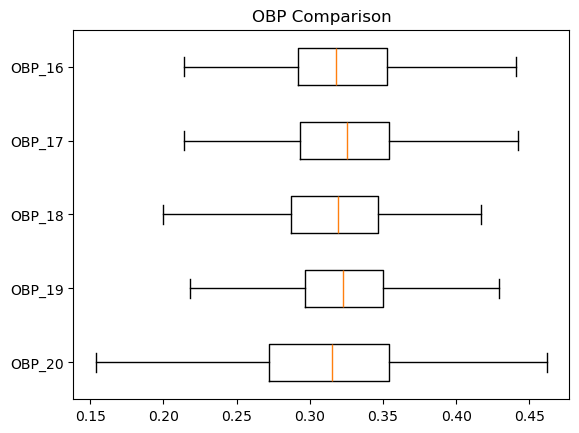

In [825]:
plt.boxplot([eda['OBP_20'].dropna(), 
             eda['OBP_19'].dropna(), 
             eda['OBP_18'].dropna(), 
             eda['OBP_17'].dropna(), 
             eda['OBP_16'].dropna()],
            labels=['OBP_20', 'OBP_19', 'OBP_18','OBP_17', 'OBP_16'], showfliers=False, vert=False)
plt.title('OBP Comparison')
plt.show()

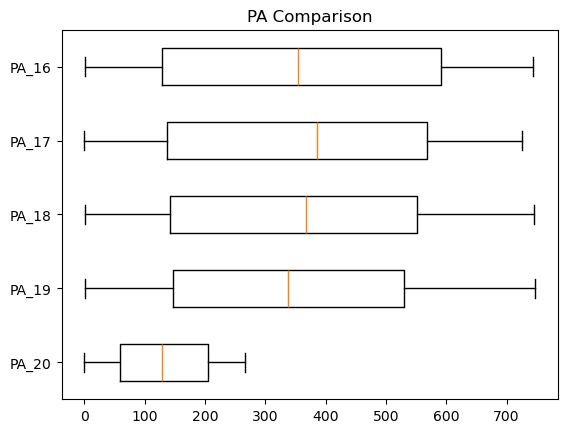

In [826]:
plt.boxplot([eda['PA_20'].dropna(), 
             eda['PA_19'].dropna(), 
             eda['PA_18'].dropna(), 
             eda['PA_17'].dropna(), 
             eda['PA_16'].dropna()],
            labels=['PA_20', 'PA_19', 'PA_18', 'PA_17', 'PA_16'], showfliers=False, vert=False)
plt.title('PA Comparison')
plt.show()

### Correlation Analysis

In [827]:
corr = eda[['OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17',
            'PA_16', 'OBP_16', 'OBP_Avg','PA_Avg', 'Age', 'Years_Exp', 'TOB_Avg', 'TOB_19']].corr()
corr = corr[['OBP_20']].sort_values(by="OBP_20", ascending=False)
corr

,OBP_20
OBP_20,1.000000
TOB_19,0.323146
PA_19,0.298196
OBP_17,0.284678
TOB_Avg,0.282690
PA_Avg,0.255755
OBP_19,0.249889
PA_16,0.217161
OBP_Avg,0.214232
PA_18,0.190588


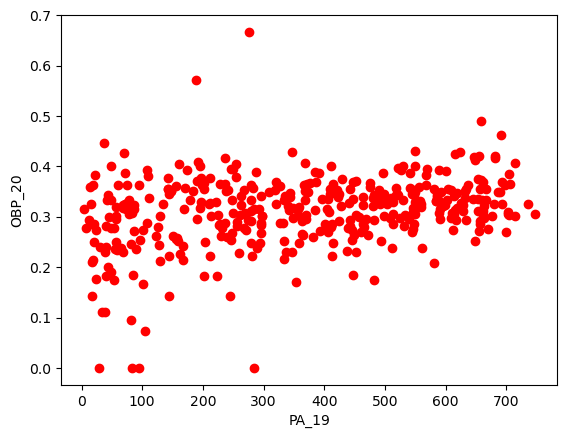

In [828]:
plt.scatter(eda['PA_19'], eda['OBP_20'], color='red')
plt.xlabel('PA_19')
plt.ylabel('OBP_20')
plt.show()

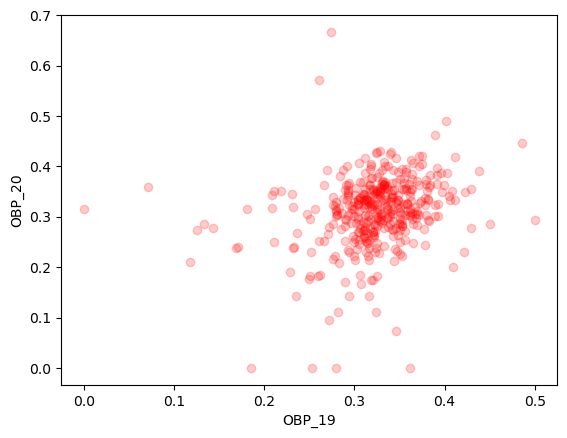

In [829]:
plt.scatter(eda['OBP_19'], eda['OBP_20'], color='red', alpha=0.2)
plt.xlabel('OBP_19')
plt.ylabel('OBP_20')
plt.show()

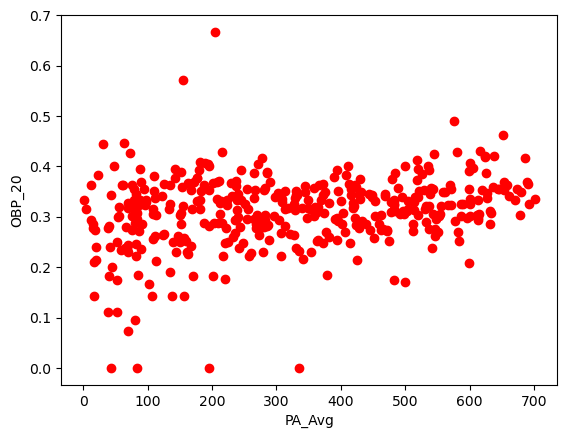

In [830]:
plt.scatter(eda['PA_Avg'], eda['OBP_20'], color='red')
plt.xlabel('PA_Avg')
plt.ylabel('OBP_20')
plt.show()

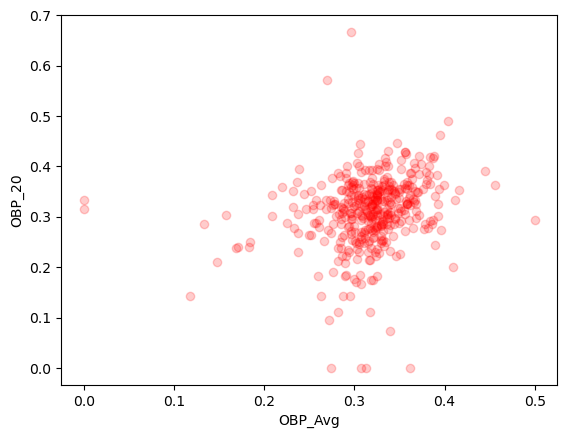

In [831]:
plt.scatter(eda['OBP_Avg'], eda['OBP_20'], color='red', alpha=0.2)
plt.xlabel('OBP_Avg')
plt.ylabel('OBP_20')
plt.show()

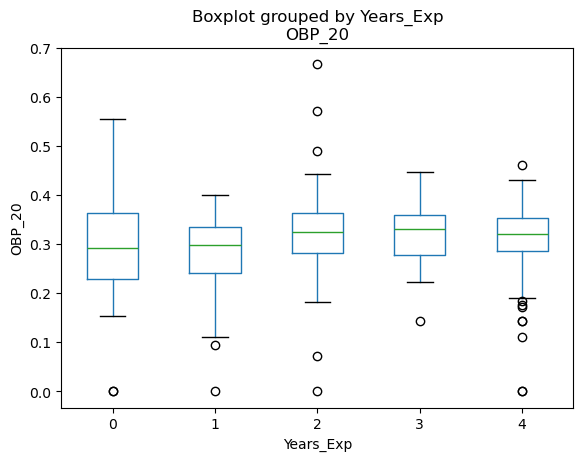

In [832]:
eda.boxplot(column='OBP_20', by='Years_Exp', vert=True)
plt.ylabel('OBP_20')
plt.grid(False)
plt.show()

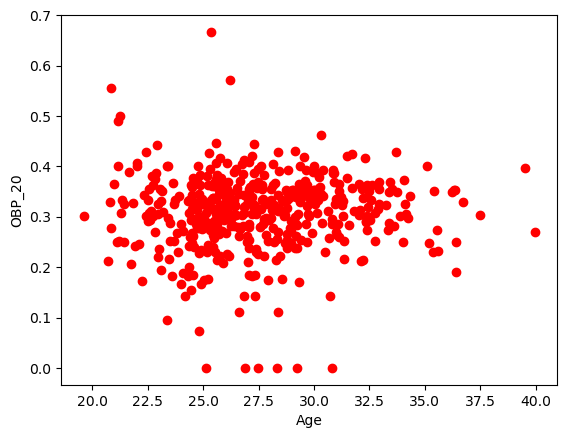

In [833]:
plt.scatter(eda['Age'], eda['OBP_20'], color='red')
plt.xlabel('Age')
plt.ylabel('OBP_20')
plt.show()

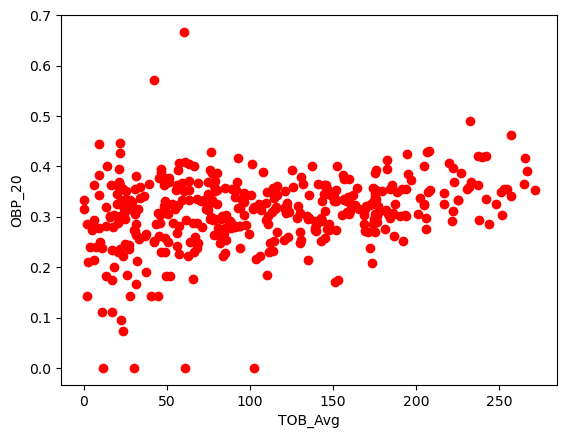

In [834]:
plt.scatter(eda['TOB_Avg'], eda['OBP_20'], color='red')
plt.xlabel('TOB_Avg')
plt.ylabel('OBP_20')
plt.show()

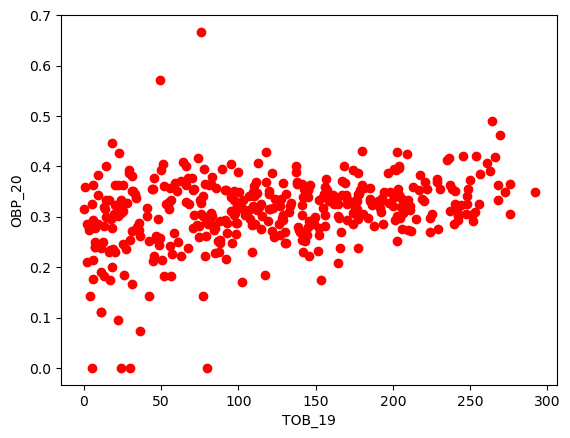

In [835]:
plt.scatter(eda['TOB_19'], eda['OBP_20'], color='red')
plt.xlabel('TOB_19')
plt.ylabel('OBP_20')
plt.show()

# Robust Multiple Linear Regression Model

### Feature Selection

After conducting an exploratory data analysis, including correlation assessments and scatterplot reviews, I identified the following features with the most predictive power for modeling OBP_20.

- **OBP_19**: On-base percentage in 2019.
- **OBP_Avg**: Average on-base percentage over the 2016-2019 seasons.
- **PA_19**: Plate appearances in 2019.
- **PA_Avg**: Average plate appearances over the 2016-2019 seasons.
- **TOB_19**: An approximation of Time on Base in 2019, calculated as `OBP_19 * PA_19`.
- **TOB_Avg**: An approximation of Time on Base over the 2016-2019 seasons, calculated as `OBP_Avg * PA_Avg`.
- **Years_Exp**: The number of years of experience before the 2020 season.

### Handling Missing Data

Due to a significant amount of missing data for roughly 20% of the players who debuted in the 2021 season, I opted for this strategy:

- Training Data: Players with missing values for the 2020 season were dropped from the training set. All other players were retained due to my feature engineering and selection.

- Testing Data: For the 2021 season, I imputed missing values for newer players using the median values for the 2020 season. The median was chosen over the mean to minimize the impact of outliers. Again, due to my feature engineering and selection, I did not need to impute any other values. 

### Model Choice

Given the linear relationships observed between the selected features and the target variable, I chose a multiple linear regression model. **Due to my strategy for handling the missing values of the new players, the quick turnaround needed for this project, and the grading criteria emphasizing clarity over accuracy, I did not implement a hierarchical model, although I understand it could be a better option.**

In [836]:
train['OBP_Avg'] = train[['OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].mean(axis=1)
train['PA_Avg'] = train[['PA_19', 'PA_18', 'PA_17', 'PA_16']].mean(axis=1)
train['Years_Exp'] = train[['OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].count(axis=1)
train['TOB_Avg'] = train['OBP_Avg'] * train['PA_Avg']
train['TOB_19'] = train['OBP_19'] * train['PA_19']
train = train[['Name', 'OBP_20', 'OBP_19', 'OBP_Avg', 'PA_19', 'PA_Avg', 'TOB_19', 'TOB_Avg', 'Years_Exp']].copy()
train.dropna(inplace = True)

### Distribution & Prior Selection

The distribution of OBP is approximately normal, with a few visible outliers. To account for these outliers, I selected a Student's T-distribution for the likelihood function. The Student's T-distribution is more robust than the normal distribution when dealing with outliers, as it assigns less weight to data points that are far from the bulk of the data. This is a good choice as the Student's T-Disirbution ensures any outliers will have less influance on the regression line. 

For the priors:

- Alpha/Intercept: Set as a normally distributed prior centered around 0.32, which reflects the league-average OBP over many years. This informative prior helps anchor the model in the historical context of the data.
- Beta/Coefficients: Set as uninformative priors, normal distribution with mean 0 and standard deviation 1. 

In [837]:
#Citation/Inspiration: Chapter 4 - Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

with pm.Model() as model:
   
    #Priors
    alpha = pm.Normal('alpha', mu=0.32, sigma=0.1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    beta6 = pm.Normal('beta6', mu=0, sigma=1)
    beta7 = pm.Normal('beta7', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    nu = pm.Exponential('nu', 1/30)
    
    #Deterministic 
    mu = pm.Deterministic('mu', alpha + 
                          beta1 * train.OBP_19 +
                          beta2 * train.OBP_Avg +
                          beta3 * train.PA_19 +
                          beta4 * train.PA_Avg +
                          beta5 * train.TOB_19 +
                          beta6 * train.TOB_Avg +
                          beta7 * train.Years_Exp)
    
    obp_pred = pm.StudentT('obp_pred', mu=mu, sigma=sigma, nu=nu, observed=train.OBP_20)
    idata = pm.sample(return_inferencedata=True, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


### Sampling Checks
No issues arose during sampling from the posterior distribution, with 0 divergences and a runtime of 30 seconds. Both plots for all unobserved variables show that it is hard to distinguish one chain from another, and there are no clear patterns, indicating that the sampler properly explored the posterior distribution.

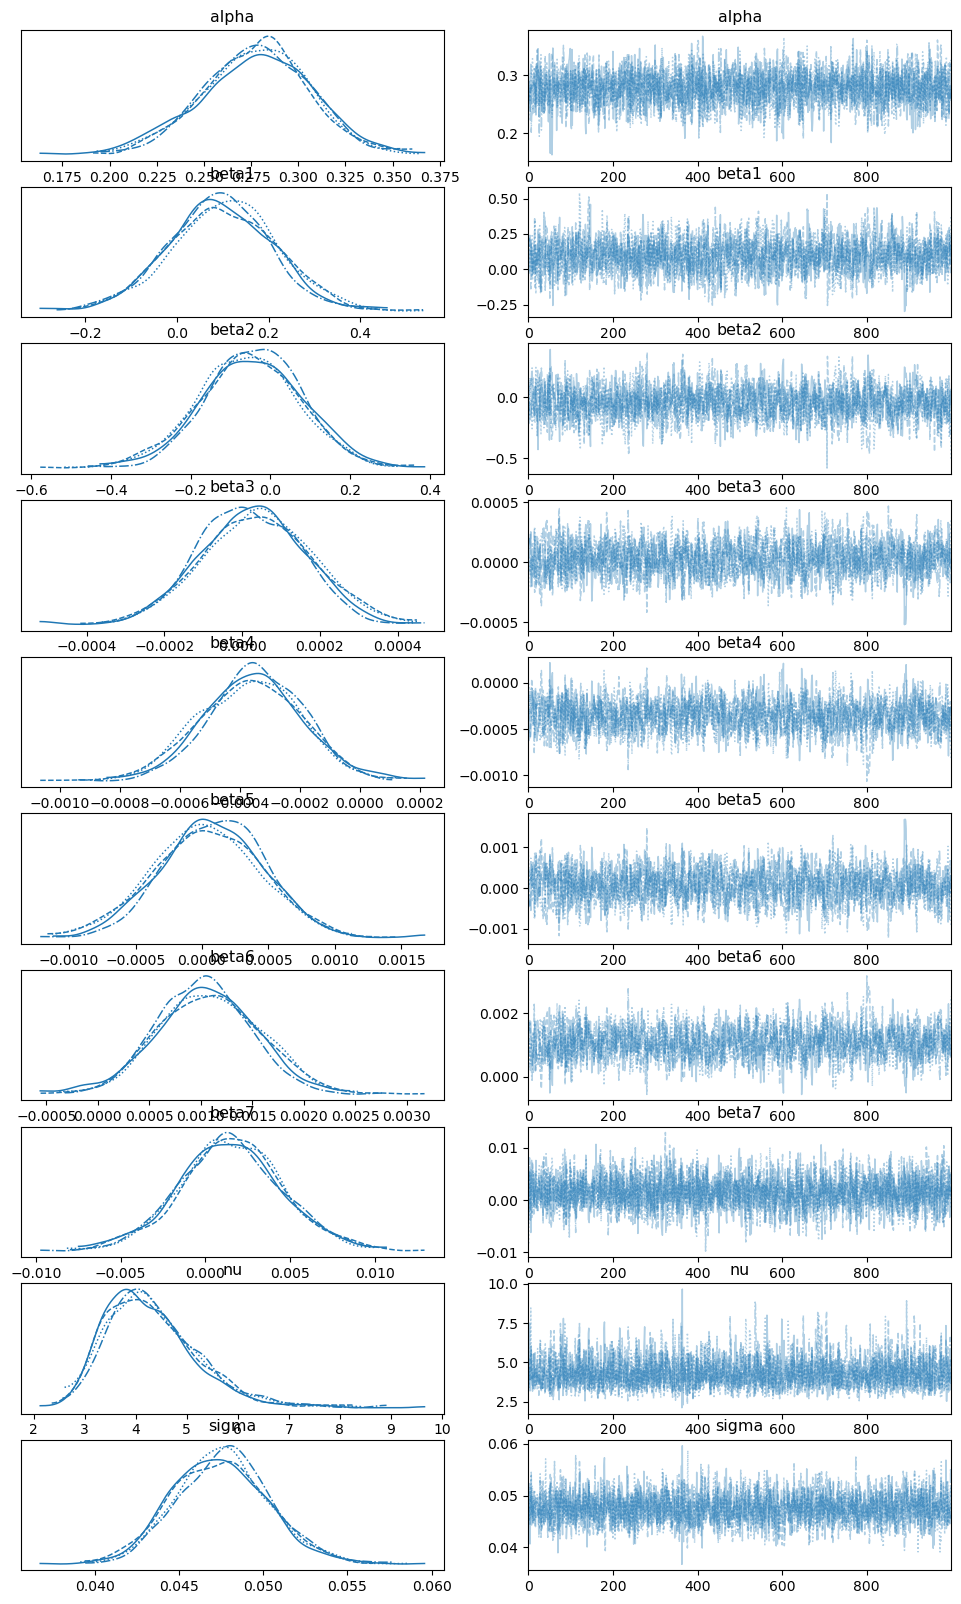

In [838]:
#Citation/Inspiration: Chapter 2 - Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

az.plot_trace(idata, var_names=["~mu"]) #intentially omitting the deterministic variable mu
plt.show()

### Posterior Plots

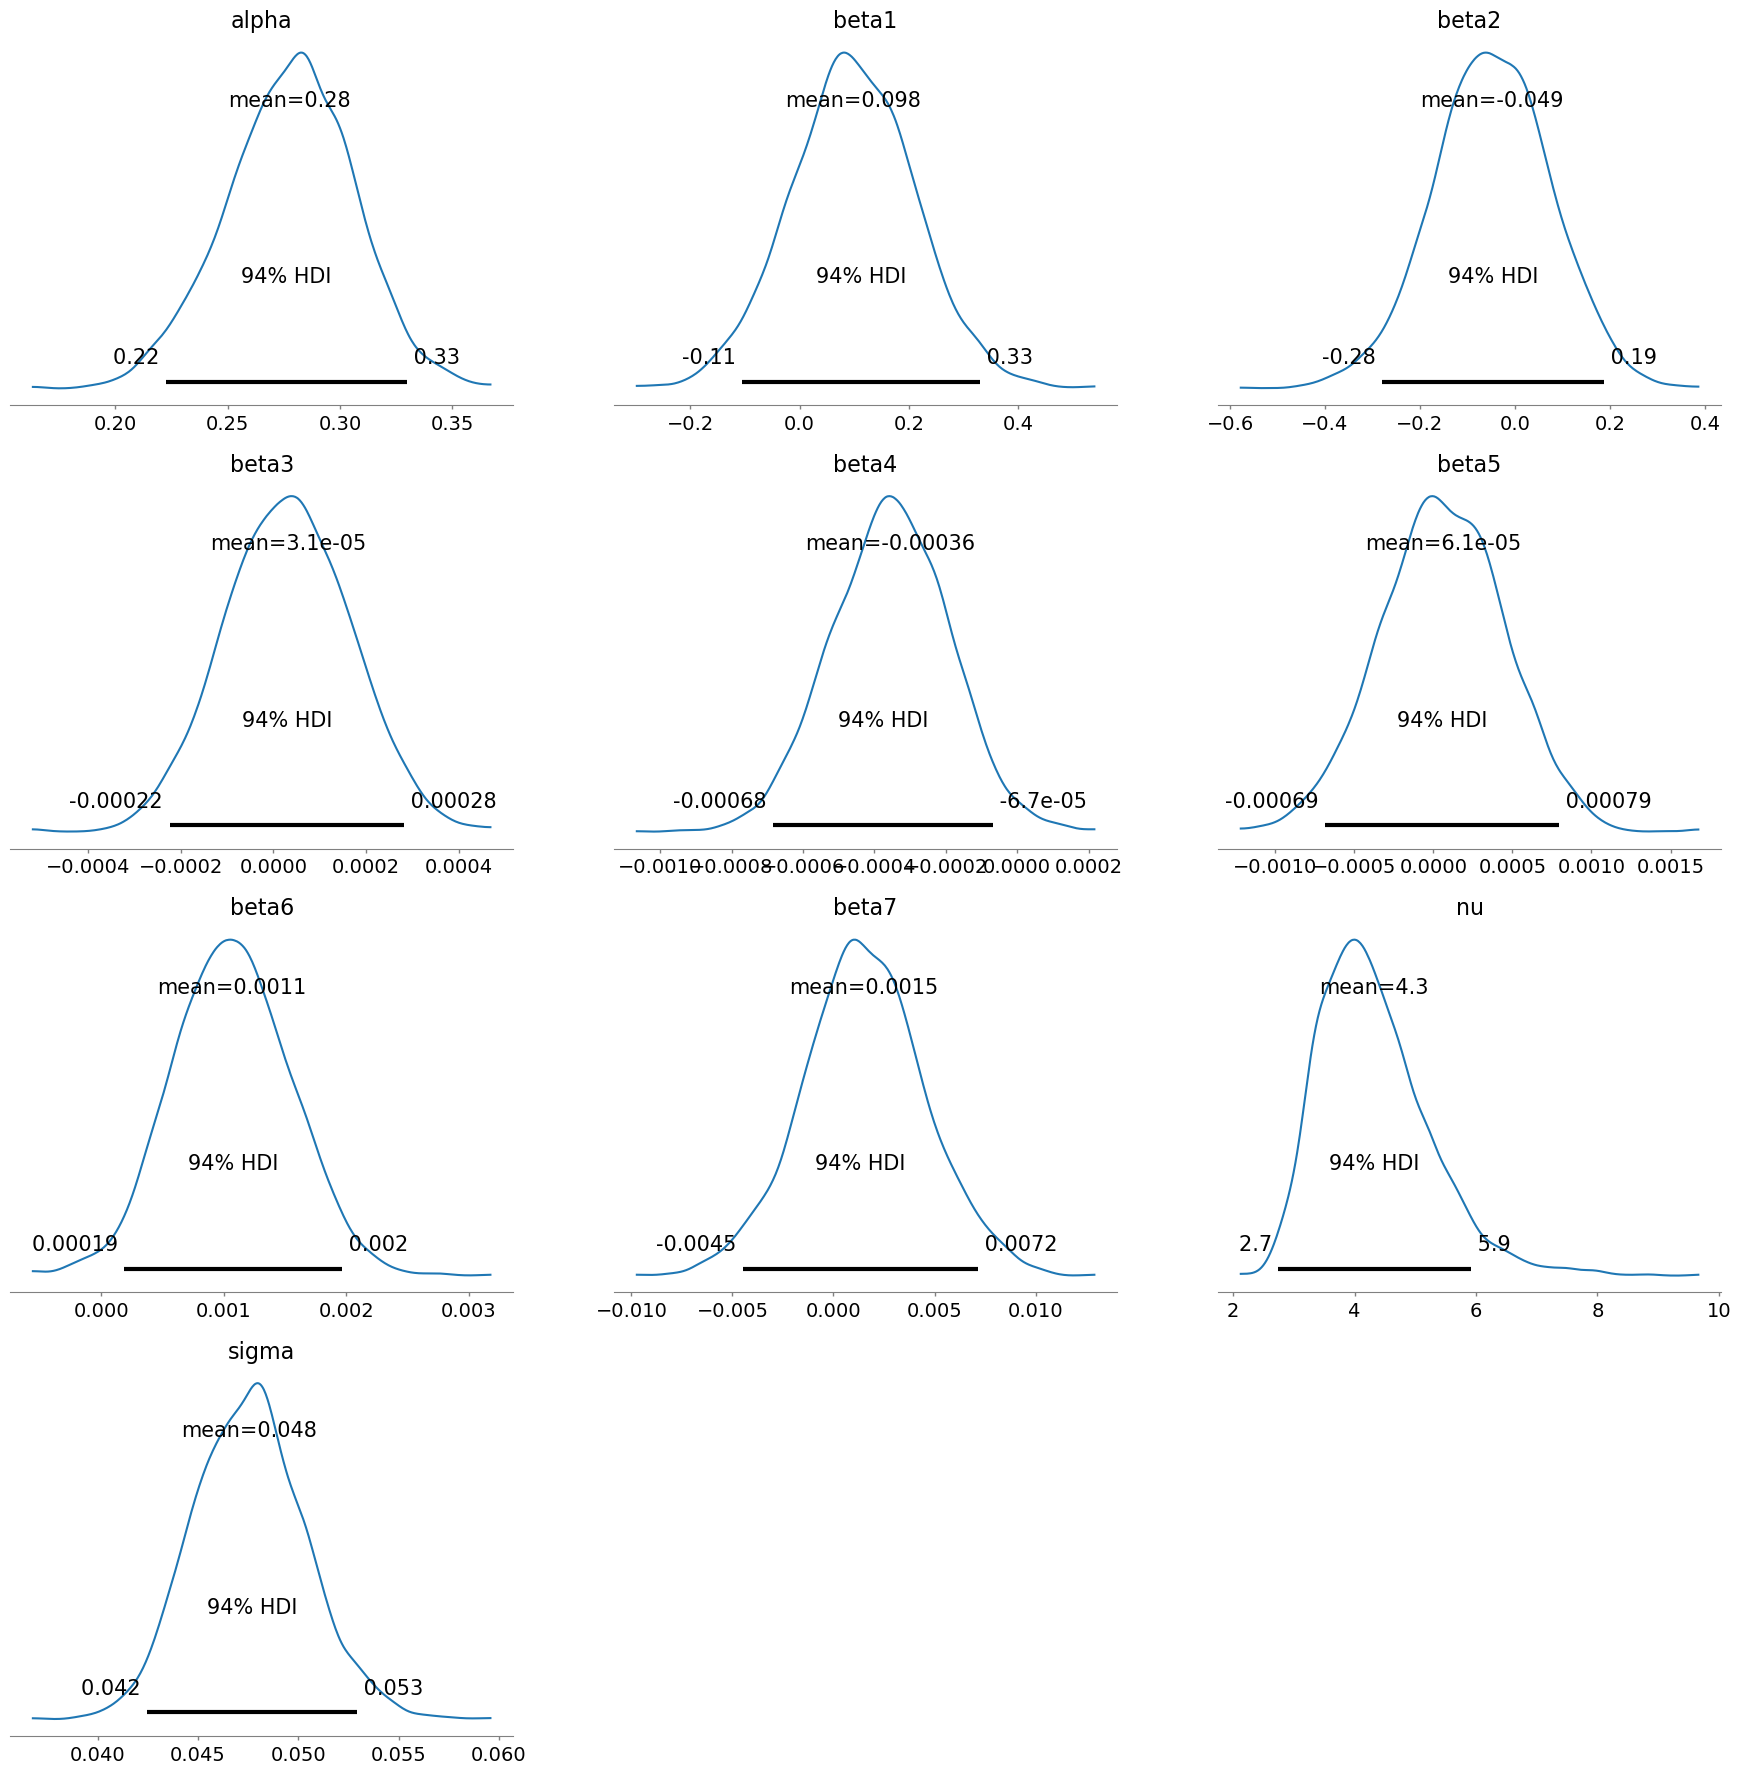

In [839]:
#Citation/Inspiration: Chapter 4 - Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

az.plot_posterior(idata, var_names=['~mu'])
plt.show()

In [840]:
#Citation/Inspiration: Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True, random_seed=123)

Sampling: [obp_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

### Posterior Predictive Checks

For most of the data, there is an almost perfect match between the posterior and observed data. The model predicts values slightly to the left of the observed data but is generally accurate enough to proceed.

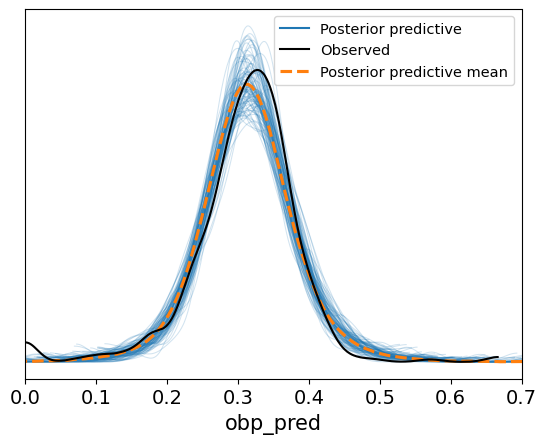

In [841]:
#Citation/Inspiration: Chapter 2 - Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

az.plot_ppc(idata, num_pp_samples=100)
plt.xlim(0,0.7)
plt.show()

### Cross-Validation

To assess the model's performance before using the testing data, I used Leave-One-Out Cross-Validation (LOO). The Pareto k diagnostic values indicate the reliability of the LOO cross-validation, and the results are all "good."

In [842]:
#Citation/Inspiration: Chapter 5 - Bayesian Analysis with Python (Third Edition) by Osvaldo Martin

idata_ll = pm.compute_log_likelihood(idata, model=model)
az.waic(idata_ll)
az.loo(idata_ll)

Output()

/Users/gibsonhurst/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 400 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   544.28    20.34
p_loo       10.53        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      400  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Residual Check

Residuals for the prediction of `OBP_20` show no strong pattern and are normally distributed, centered at zero. Since all these model checks look good, I can proceed with predicting OBP for 2021.

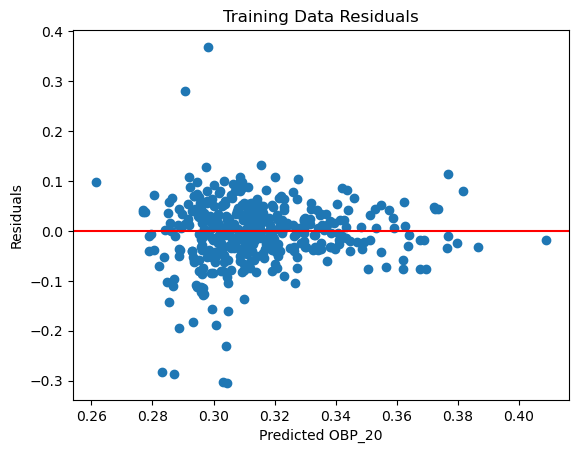

In [843]:
posterior_pred = idata.posterior_predictive['obp_pred']
pred = posterior_pred.mean(dim=("chain", "draw")).values
train_residuals = train.OBP_20 - pred
plt.scatter(pred, train_residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted OBP_20')
plt.ylabel('Residuals')
plt.title('Training Data Residuals')
plt.show()

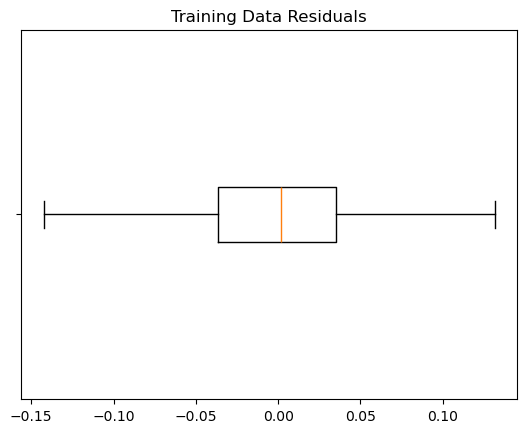

In [844]:
plt.boxplot(train_residuals,
            labels=[''],
            showfliers=False, 
            vert=False)
plt.title('Training Data Residuals')
plt.show()

# 2021 Prediction

At this stage I made inferences on the testing data. All variables are shifted one year forwards but use the same coeficients from the model. For example, `OBP_21` is now the target variable and `OBP_20` is the first predictor using the `beta1` coeficient trained on `OBP_19`.

**Simplified Structure**\
Train: OPB_20 ~ OBP_19 + OBP_Avg + PA_19 + PA_Avg + TOB_19 + TOB_Avg + Years_Exp\
Test: OPB_21 ~ OBP_20 + OBP_Avg + PA_20 + PA_Avg + TOB_20 + TOB_Avg + Years_Exp

I want to reiterate that I imputed `OBP_20` & `PA_20` for the players with no prior data, and their `Years_Exp` will be 0. Also, their OBP and PA averages will equal the imputed 2020 values.

In [845]:
test.isnull().sum() / len(eda)

Name          0.000000
playerid      0.000000
birth_date    0.000000
PA_21         0.000000
OBP_21        0.000000
PA_20         0.185315
OBP_20        0.185315
PA_19         0.236014
OBP_19        0.236014
PA_18         0.372378
OBP_18        0.372378
PA_17         0.479021
OBP_17        0.479021
PA_16         0.568182
OBP_16        0.568182
dtype: float64

In [846]:
test['Years_Exp'] = test[['OBP_20', 'OBP_19', 'OBP_18', 'OBP_17']].count(axis=1)
test['PA_20'] = test['PA_20'].fillna(test['PA_20'].median())
test['OBP_20'] = test['OBP_20'].fillna(test['OBP_20'].median())
test['OBP_Avg'] = test[['OBP_20', 'OBP_19', 'OBP_18', 'OBP_17']].mean(axis=1)
test['PA_Avg'] = test[['PA_20', 'PA_19', 'PA_18', 'PA_17']].mean(axis=1)
test['TOB_Avg'] = test['OBP_Avg'] * test['PA_Avg']
test['TOB_20'] = test['OBP_20'] * test['PA_20']
test = test[['Name', 'OBP_21', 'OBP_20', 'OBP_Avg', 'PA_20', 'PA_Avg', 'TOB_20', 'TOB_Avg', 'Years_Exp']].copy()

In [847]:
#Citation/Inspiration: ChatGPT

alpha_samples = idata.posterior['alpha'].values.flatten()
beta1_samples = idata.posterior['beta1'].values.flatten()
beta2_samples = idata.posterior['beta2'].values.flatten()
beta3_samples = idata.posterior['beta3'].values.flatten()
beta4_samples = idata.posterior['beta4'].values.flatten()
beta5_samples = idata.posterior['beta5'].values.flatten()
beta6_samples = idata.posterior['beta6'].values.flatten()
beta7_samples = idata.posterior['beta7'].values.flatten()

mu_test = (alpha_samples[:, None] +
           beta1_samples[:, None] * test['OBP_20'].values +
           beta2_samples[:, None] * test['OBP_Avg'].values +
           beta3_samples[:, None] * test['PA_20'].values +
           beta4_samples[:, None] * test['PA_Avg'].values +
           beta5_samples[:, None] * test['TOB_20'].values +
           beta6_samples[:, None] * test['TOB_Avg'].values +
           beta7_samples[:, None] * test['Years_Exp'].values)

mean_predictions = mu_test.mean(axis=0)


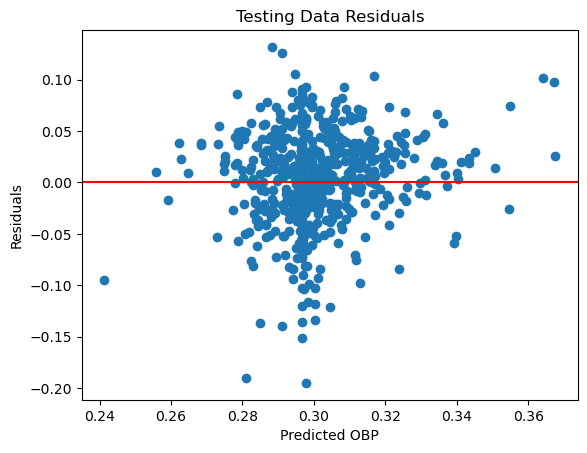

In [848]:
residuals_model = test.OBP_21 - mean_predictions
plt.scatter(mean_predictions, residuals_model)
plt.axhline(0, color='red')
plt.xlabel('Predicted OBP')
plt.ylabel('Residuals')
plt.title('Testing Data Residuals')
plt.show()

## Baseline Comparison

Model performance metrics are somewhat meaningless unless compared to a real-world baseline. Here, I developed two baseline heuristics for predicting `OBP_21`. The first is simply the player's OBP from 2020 or the league median if they are debuting in 2021. The second is the player's average OBP from 2016-2020, or again the league median 2020 OBP if they are debuting in 2021.

In [849]:
mse_model = mean_squared_error(test['OBP_21'], mean_predictions)
mse_20 = mean_squared_error(test['OBP_21'], test['OBP_20'])
mse_avg = mean_squared_error(test['OBP_21'], test['OBP_Avg'])

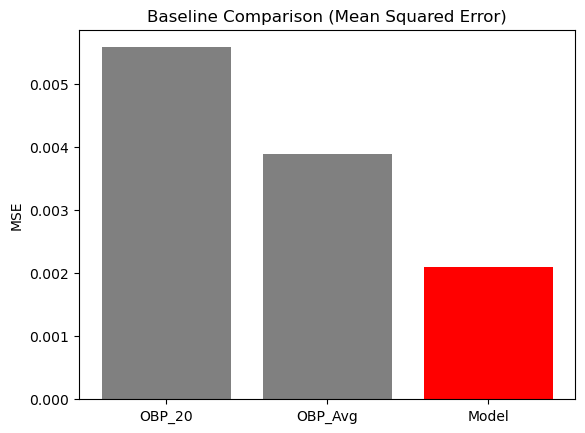

In [850]:
mse_values = [mse_20, mse_avg, mse_model]
labels = ['OBP_20', 'OBP_Avg', 'Model']
plt.bar(labels, mse_values, color=['gray', 'gray', 'red'])
plt.title('Baseline Comparison (Mean Squared Error)')
plt.ylabel('MSE')
plt.show()

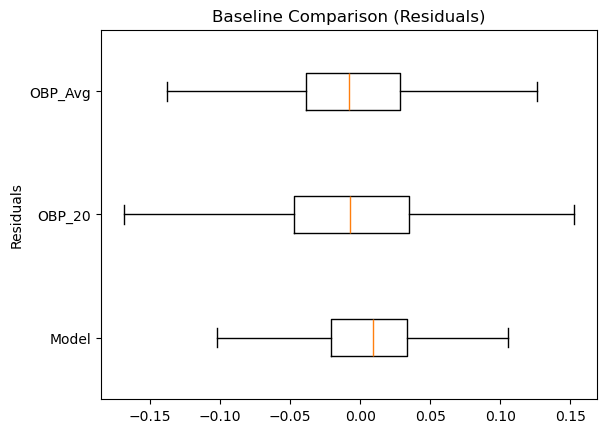

In [851]:
residuals_20 = test.OBP_21 - test.OBP_20
residuals_avg = test.OBP_21 - test.OBP_Avg
test_residuals = pd.DataFrame({'Model': residuals_model,
                               'OBP_20': residuals_20,
                               'OBP_Avg': residuals_avg,})

plt.boxplot([test_residuals['Model'], 
             test_residuals['OBP_20'],
             test_residuals['OBP_Avg']],
            labels=['Model', 'OBP_20', 'OBP_Avg'], showfliers=False, vert=False)
plt.title('Baseline Comparison (Residuals)')
plt.ylabel('Residuals')
plt.show()

In [852]:
mse_table = pd.DataFrame({'Method': labels, 'MSE Value': mse_values})
mse_table

,Method,MSE Value
0,OBP_20,0.005576
1,OBP_Avg,0.003886
2,Model,0.002101


## Conclusion

In this analysis I developed a Bayesian regression model to predict players' on-base percentages (OBP) for the 2021 MLB season using historical data from 2016-2020. **My model successfully has both a lower Mean Squared Error and smaller residuals relative to the two baseline heuristics.**

With in-depth data analysis and sound modeling choices, I created a robust, interpretable model that effectively predicts player `OBP_21` while working within the constraints of the available data and project deadline.

The last block of code contains the requested predicted values.

### Limitations
- The dataset is limited to player performance metrics from 2016-2020, and no additional player statistics were included in the analysis.
- The linear regression model used does not incorporate a hierarchical structure or hyperpriors, which could better capture player-specific effects within a Bayesian framework and improve predictive performance.
- The use of median imputation for handling missing data is a simple approach. More advanced methods, such as KNN, could provide better imputation results and might be unnecessary if a hierarchical model structure were used.

### Future Work
One of my favorite aspects of data analytics is the almost endless depth of which I could further explore every step in this process. Some ideas that come to mind inlcude:
- Incorporate additional data sources such as minor league data for debuing players
- Explore more advanced Bayesian modeling techniques
- Additional feature engineering

### Thank You
I’m truly grateful for the chance to work on this project. It has been a valuable learning experience, building on everything I’ve taken away from attending the Phillies Business Analytics Night, participating in the Phillies Data Hackathon, and conversations I've had with members of the R&D group. These experiences, combined with my background in statistics, have made me feel more aligned than ever about the possibility of joining the Phillies R&D group. Thank you for considering my application!

### Predictions DataFrame

In [853]:
predictions_2021 = pd.DataFrame({
    'Name': test.Name,
    'OBP_21': test.OBP_21,
    'Pred_OBP_21': mean_predictions
})
predictions_2021

,Name,OBP_21,Pred_OBP_21
0,Trayce Thompson,0.400,0.294798
1,Mike Trout,0.466,0.364293
2,Bryce Harper,0.429,0.354945
3,Chris Owings,0.420,0.288329
4,Nick Fortes,0.353,0.296765
5,Juan Soto,0.465,0.367176
6,Vladimir Guerrero Jr.,0.401,0.308318
7,Byron Buxton,0.358,0.284776
8,Ronald Acuna Jr.,0.394,0.336228
9,Brandon Belt,0.378,0.330982
